# Подключаем нужные библиотеки

In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

In [2]:
SEED = 1488

import random
random.seed(SEED)
np.random.seed(SEED)

import tqdm
import pandas as pd

import importlib
%load_ext autoreload
%autoreload 2

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [3]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [4]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [5]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 161 ms, sys: 3.47 ms, total: 164 ms
Wall time: 193 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [6]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [7]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=int(1e+7), random_state=SEED)

CPU times: user 41.7 ms, sys: 150 ms, total: 192 ms
Wall time: 218 ms


Пример того, как выглядят тесты для полноградиентного случая

In [8]:
%%time
x = norm_d.rvs(size=n)

CPU times: user 141 µs, sys: 0 ns, total: 141 µs
Wall time: 143 µs


In [9]:
num_of_tests = 600

In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

CPU times: user 6.62 s, sys: 0 ns, total: 6.62 s
Wall time: 6.63 s


In [11]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

CPU times: user 19.9 s, sys: 0 ns, total: 19.9 s
Wall time: 19.9 s


Пример тестов для случая стох. градиентов

In [12]:
batch_size = 1
num_of_tests = 10000

In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

CPU times: user 7.22 s, sys: 4.09 ms, total: 7.22 s
Wall time: 7.21 s


In [14]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 513 ms


In [15]:
def sparse_vs_dense_experiment(dataset_name, random_seed=SEED):
    # load data
    num_of_tests = 100
    A, y, m, n, sparsity_A = prepare_data(dataset_name)
    L, average_L, worst_L = compute_L(dataset_name, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
    
    # compute dense feature-matrix
    denseA = A.toarray()
    
    # sample indices for stochastic gradient
    batch_indices = randint.rvs(low=0, high=m, size=int(1e+7), random_state=42)
    
    # FULL GRADIENT measurements
    # sparse case
    time_sparse_gd = time.time() 
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [A, y, 0, True])
    time_sparse_gd = time.time() - time_sparse_gd
    
    # dense case
    time_dense_gd = time.time()    
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [denseA, y, 0, False])
    time_dense_gd = time.time() - time_dense_gd
    
    # STOCHASTIC GRADIENT measurements
    times_sparse_sgd =[]
    times_dense_sgd = []
    
    for batch_size in [1, 10, 100]:
        # sparse case
        t_start = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
        times_sparse_sgd.append(time.time() - t_start)
        
        # dense case
        t_start = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
        times_dense_sgd.append(time.time() - t_start)
    
    return {'Dataset': dataset_name, 'Num objects': m, 'Num features': n, 'L': L, 'Average L': average_L,
            'Worst L': worst_L, 'Sparsity': sparsity_A, 'Sparse FullG Time': time_sparse_gd,
            'Dense FullG Time': time_dense_gd, 'Sparse StochasticG Time (batch 1)': times_sparse_sgd[0],
            'Dense StochasticG Time (batch 1)': times_dense_sgd[0], 
            'Sparse StochasticG Time (batch 10)': times_sparse_sgd[1], 
            'Dense StochasticG Time (batch 10)': times_dense_sgd[1],
            'Sparse StochasticG Time (batch 100)': times_sparse_sgd[2],
            'Dense StochasticG Time (batch 100)': times_dense_sgd[2]}

In [16]:
dataset_names = ['a9a', 'gisette', 'australian', 'german_numer', 'heart']
experiment_results = []
for dataset_name in tqdm.tqdm(dataset_names):
    experiment_results.append(sparse_vs_dense_experiment(dataset_name))
experiment_results_df = pd.DataFrame(experiment_results)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:30<00:00, 18.17s/it]


Зафиксируйте здесь результаты своих экспериментов:

In [38]:
experiment_results_df

,Dataset,Num objects,Num features,L,Average L,Worst L,Sparsity,Sparse FullG Time,Dense FullG Time,Sparse StochasticG Time (batch 1),Dense StochasticG Time (batch 1),Sparse StochasticG Time (batch 10),Dense StochasticG Time (batch 10),Sparse StochasticG Time (batch 100),Dense StochasticG Time (batch 100)
0,a9a,32561,123,1.571920e+00,3.467277e+00,3.500000e+00,0.112757,1.881328,3.486574,0.072573,0.005143,0.073459,0.006062,0.080375,0.014602
1,gisette,6000,5000,8.428680e+02,1.163345e+03,1.201509e+03,0.991000,63.597321,9.831613,0.084533,0.015573,0.152914,0.027859,1.646257,0.456541
2,australian,690,14,7.036285e+06,7.051932e+06,2.500101e+09,0.799586,0.051662,0.009674,0.071426,0.005049,0.073247,0.005456,0.076584,0.007035
3,german_numer,1000,24,8.436612e+02,9.798927e+02,9.305750e+03,0.749542,0.064637,0.011727,0.072414,0.005018,0.073113,0.005460,0.078080,0.006902
4,heart,270,13,2.671068e+04,2.714773e+04,9.036964e+04,0.750997,0.042998,0.005928,0.072798,0.005090,0.073361,0.005433,0.077478,0.006511


### Counclusion по Заданию 1
**Вариации вычисления градиента, отсортированные по возрастанию времени работы**
```
a9a: 1D - 10D - 100D - 1S - 10S - 100S - FS - FD  
gisette: 1D - 10D - 1S - 10S - 100D - 100S - FD - FS  
australian: 1D - 10D - 100D - FD - FS - 1S - 10S - 100S  
german_numer: 1D - 10D - 100D - FD - FS - 1S - 10S - 100S  
heart: 1D - 10D - FD - 100D - FS - 1S - 10S - 100S  
```
По результатам, приведенным в таблице, видно, что по времени вычислений dense-варианты превосходят аналогичные sparse, но "оплачивается" это бОльшим потреблением ram.

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [6]:
#напишите код в этой ячейке
def prox_R(x, lamb):
    return np.maximum(np.abs(x) - lamb, 0) * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [20]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [58]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
CPU times: user 134 ms, sys: 12 ms, total: 146 ms
Wall time: 144 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [46]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.01 ms


array([13381, 29739,  5207, ...,    40, 12394,  4185])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [47]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

CPU times: user 45 s, sys: 27.2 ms, total: 45.1 s
Wall time: 45 s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [26]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [27]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epoch:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]

CPU times: user 1.98 s, sys: 43.9 ms, total: 2.03 s
Wall time: 2.03 s


Запустите функцию, тестирующую корректность работы

In [24]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [8]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [9]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [10]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [12]:
# Task 3 Experiment 1 (Custom vs Default solvers comparison for a9a for l1 = 0 and l1 = L / 1000)

# ваш код здесь
# задать параметры
dataset = "a9a"
filename = dataset + "_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 50
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [13]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Train epochs:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.42it/s]

Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
CPU times: user 14.6 s, sys: 30.1 ms, total: 14.7 s
Wall time: 14.6 s


In [14]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [15]:
%%time
l1 = 0
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Train epochs:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.38it/s]

Найденное значение:  0.32527807400416825
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 14.8 s, sys: 35.8 ms, total: 14.8 s
Wall time: 14.8 s


In [44]:
%%time
l1 = L / 1000
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357857
         Iterations: 986
         Function evaluations: 1063
         Gradient evaluations: 1063
0.3578568111142156
CPU times: user 24.8 s, sys: 456 ms, total: 25.3 s
Wall time: 4.23 s


In [45]:
%%time
l1 = 0
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 566
         Function evaluations: 569
         Gradient evaluations: 569
0.3252780301519581
CPU times: user 13.8 s, sys: 232 ms, total: 14 s
Wall time: 2.35 s


### Conclusion on Task 3 experiment 1
Как видно, найденные значения реализованного алгоритма и стандартного солвера для датасета a9a примерно равны

In [39]:
# Task 3 Experiment 2 (Custom vs Default solvers comparison for other datasets for l1 = L / 1000)
for dataset in dataset_names:
    if dataset == "a9a":
        continue
    print(f"SVRG on {dataset} report:")
    filename=dataset+"_x_init_all_ones"
    A, y, m, n, sparsity_A = prepare_data(dataset)
    x_init = np.ones(n)
    L, average_L, worst_L = compute_L(dataset, A) 
    # задать параметры
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 10
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = None
    f_star = None
    S = 1000
    save_info_period = 100

    #эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
    sparse_full = False
    sparse_stoch = False

    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
         l1=l1, S=S, M=M, max_t=np.inf,
         batch_size=batch_size, indices=None, save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)
    
    print("Найденное значение кастомного солвера: ", res['func_vals'][-1])

    param = [A, y, l2, True, l1]
    res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                          method="L-BFGS-B",
                          options={'maxiter':5000, 'disp':False}, tol=1e-10)

    print("Найденное значение стандартного солвера: ", res_solver.fun)

SVRG on australian report:


Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.54it/s]


Найденное значение кастомного солвера:  0.6931471805599454
Найденное значение стандартного солвера:  0.6931471815174335
SVRG on german_numer report:


Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.41it/s]


Найденное значение кастомного солвера:  0.6253992389346704
Найденное значение стандартного солвера:  0.6255283856244428
SVRG on heart report:


Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 617.59it/s]


Найденное значение кастомного солвера:  0.6931471805599453
Найденное значение стандартного солвера:  0.6931508238212118


### Conclusion on Task 3 Experiment 2
Как видно, найденные значения реализованного алгоритма и стандартного солвера для остальных датасетов примерно равны

Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [35]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [36]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epoch:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]

CPU times: user 1.41 s, sys: 24 ms, total: 1.43 s
Wall time: 1.43 s


Следующая функция позволяет строить графики

In [17]:
def make_plots(args, ax=None):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    if ax is not None:
        ax.set_title(title, fontsize=fontsize)
    else:
        plt.figure(figsize=figsize)
        plt.title(title, fontsize=fontsize)
    
    xlabel, ylabel = "", ""
    if mode_x == 'time':
        xlabel = r"Time, $s$"
    if mode_x == 'sampled_grads':
        xlabel = r"Number of sampled gradients / number of data samples"
    if mode_x == 'iters':
        xlabel = r"Number of iterations"
    if mode_y == 'squared_distances':
        ylabel = r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$"
    if mode_y == 'func_vals':
        ylabel = r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$"
    
    if ax is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        #ax.set_xticks(fontsize=fontsize)
        #_ = ax.set_yticks(fontsize=fontsize)
    else:
        plt.xlabel(xlabel, fontsize=fontsize)
        plt.ylabel(ylabel, fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        _ = plt.yticks(fontsize=fontsize)
    
    if ax is None:
        ax = plt
    
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        ax.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
    ax.legend(loc="best", fontsize=fontsize)#bbox_to_anchor=(2,1), 

In [20]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика (чтобы понимать, чему отвечает та или иная траектория)
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (10, 5)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

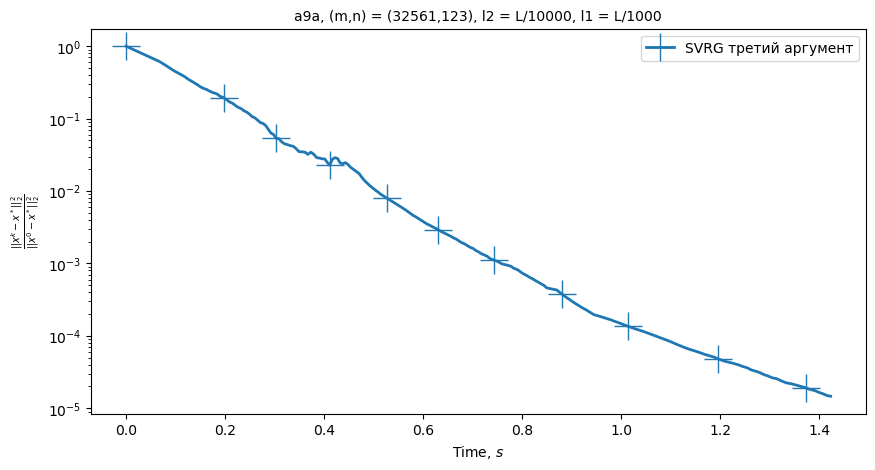

In [21]:
make_plots(args=args_for_plots);

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

In [23]:
# Task 3 Experiment 3 (trying different batch sizes and for each measuring time/num_iters/epochs)

for r in [1, 10, 100]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.05it/s]


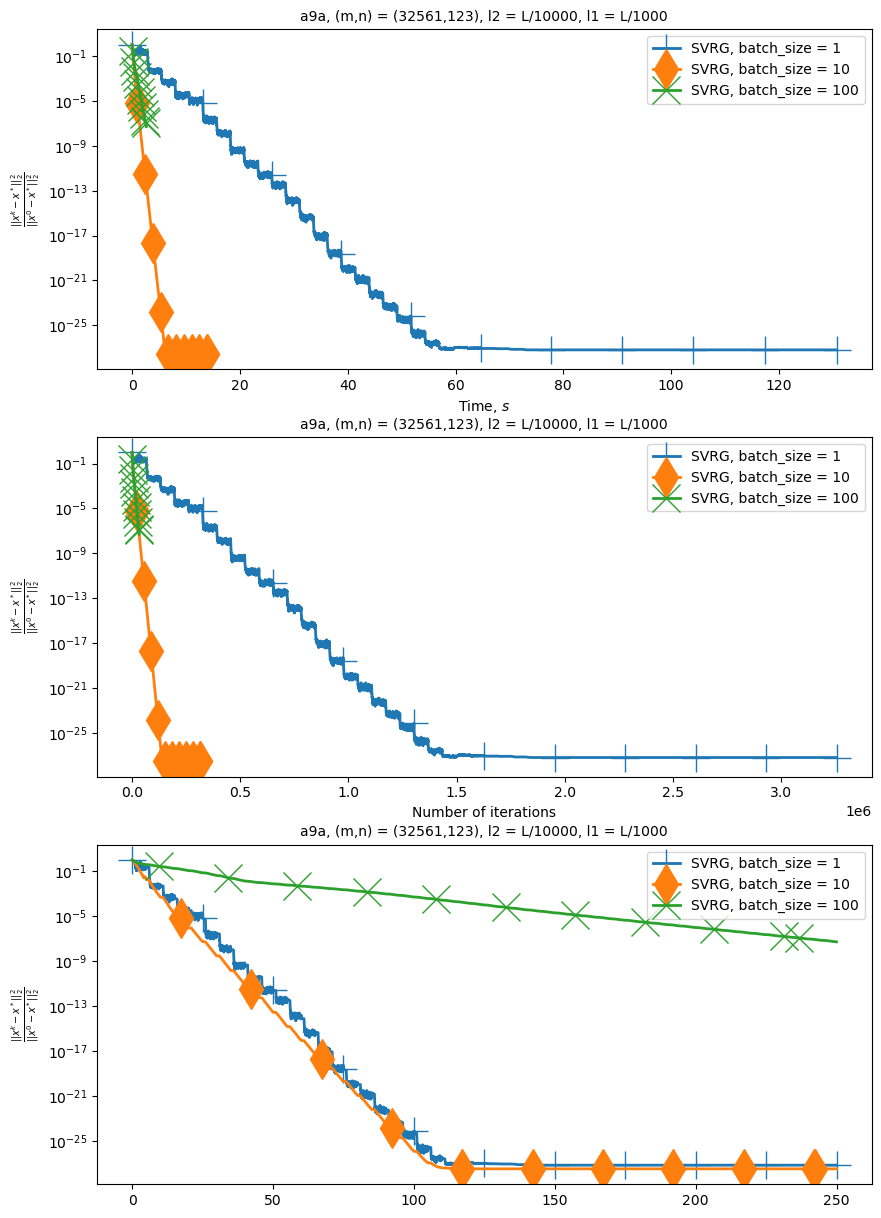

In [25]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 3 experiment 3
Как видно, быстрее всего метод сходится для батча размером 10

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [47]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [48]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 421 ms, sys: 7.99 ms, total: 429 ms
Wall time: 442 ms


Запустите функцию, тестирующую корректность работы

In [49]:
sgd_const_test(res)

Тесты пройдены!


0

In [50]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [51]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 1.33 s, sys: 4 µs, total: 1.33 s
Wall time: 1.34 s


Запустите функцию, тестирующую корректность работы

In [52]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

### Task 4 experiment 1

**Для каждого размера батча r = [1, 10, 100] запустите prox-SGD с размером шага $\gamma(\alpha) = \frac\alpha{L + l_2}$, $\alpha$ = 1, 0.1, 0.01. 
Для каждого значения r постройте графики сходимости prox-SGD с 
разными $\alpha$ (по числу итераций, эпох и времени работы).**

In [133]:
r = 1
for alpha in [1, 0.1, 0.01]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1628050/1628050 [00:55<00:00, 29579.72it/s]


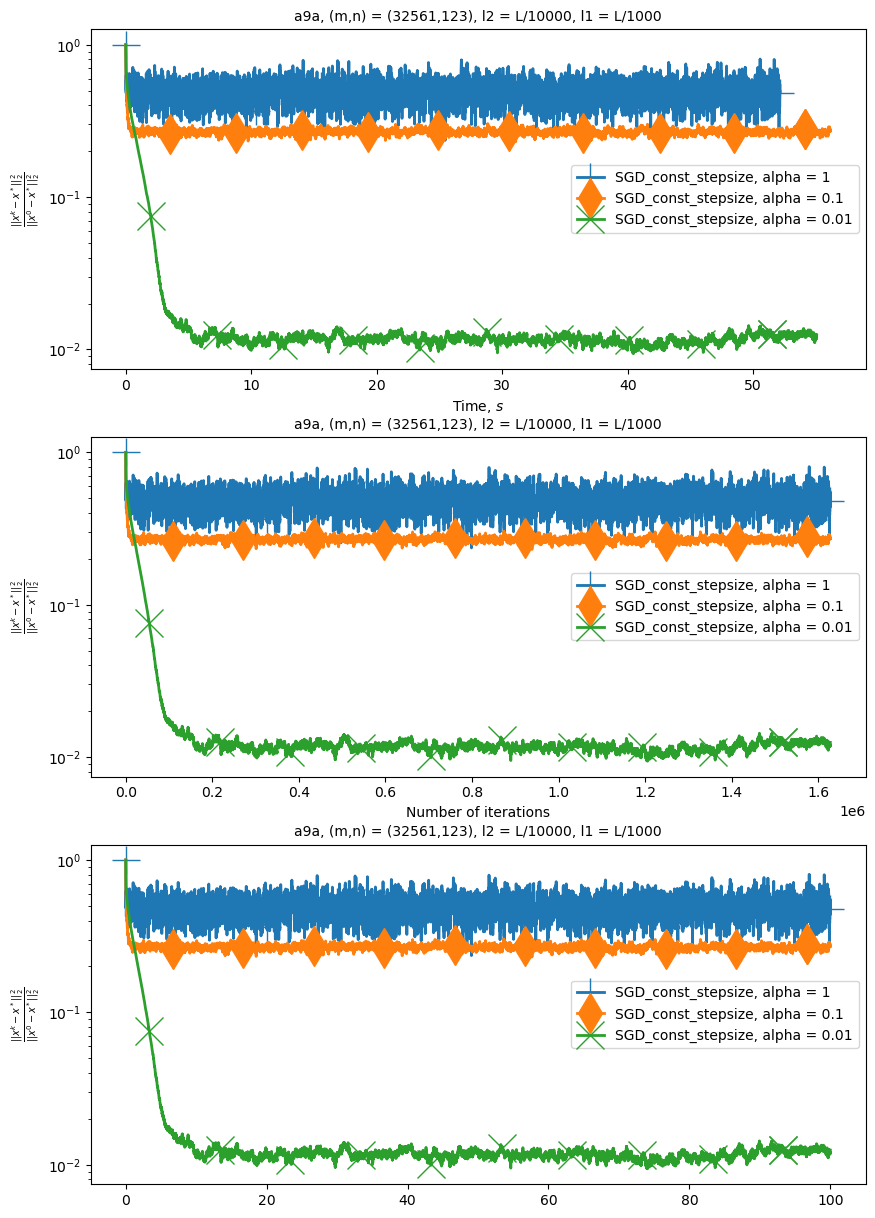

In [135]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

In [136]:
r = 10
for alpha in [1, 0.1, 0.01]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 162805/162805 [00:05<00:00, 28471.52it/s]


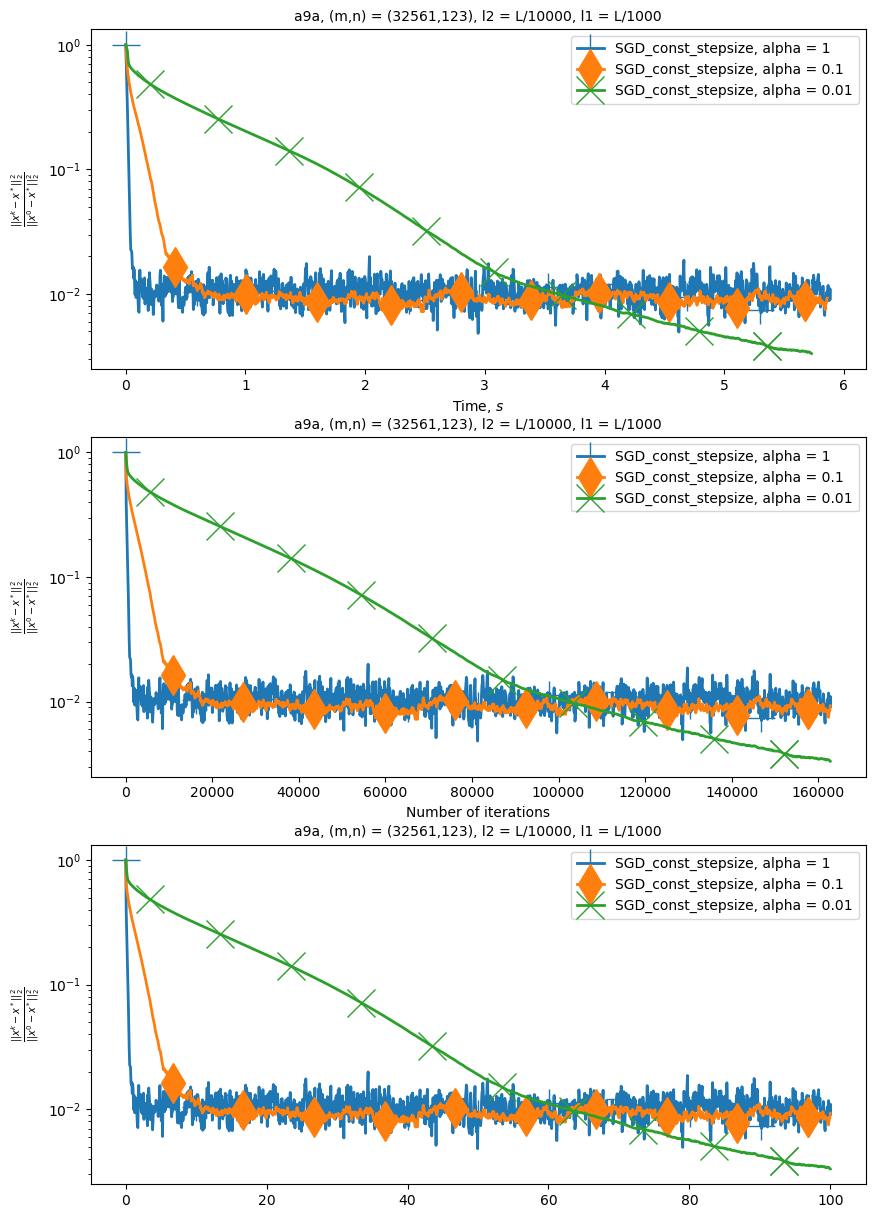

In [137]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

In [146]:
r = 100
for alpha in [1, 0.1, 0.01]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32561/32561 [00:01<00:00, 18424.86it/s]


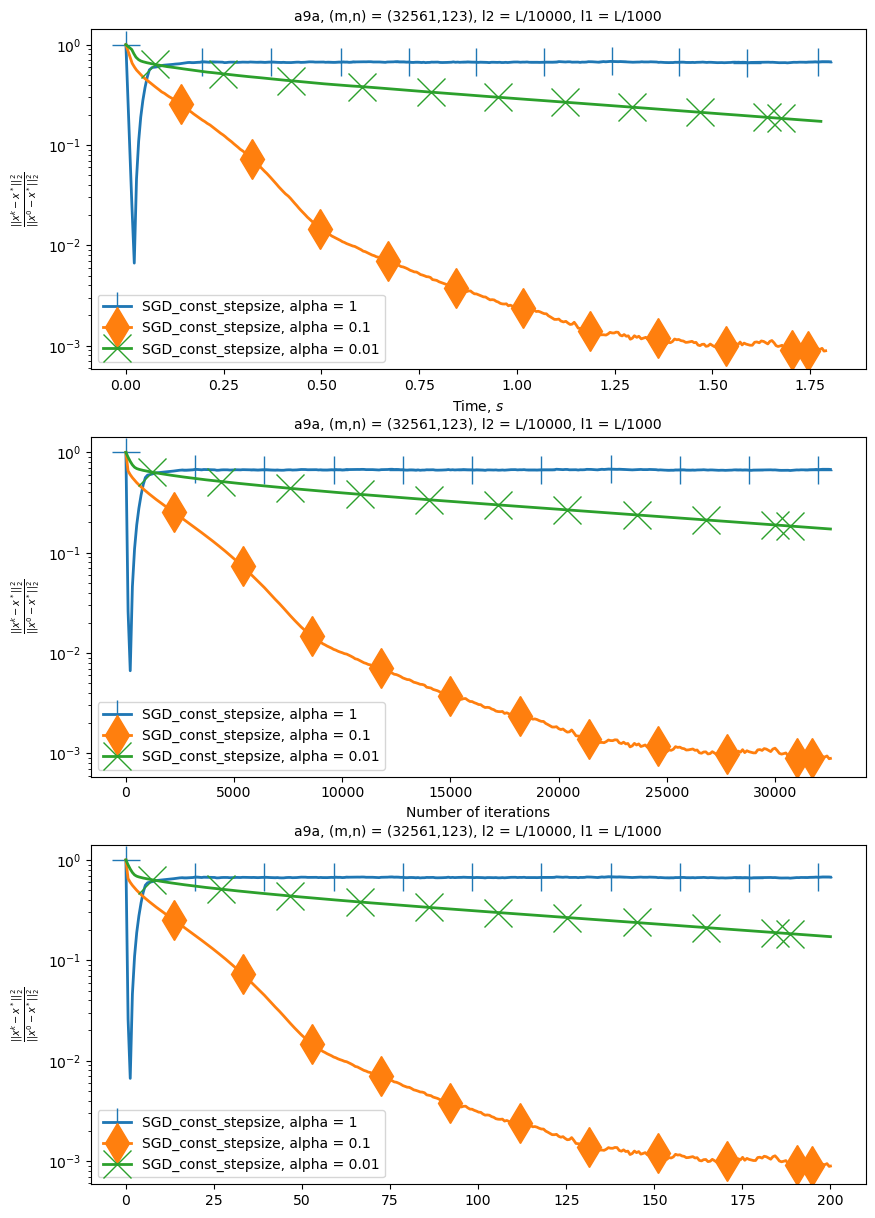

In [147]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 4 experiment 1
Лучшее alpha = 0.1 при batch_size = 100. При слишком большом значении метод может разойтись, при слишком малом будет долго сходиться.  
Так же на выбора alpha влияет размер батча.

### Task 4 experiment 2
**Для каждого размера батча r = 1, 10, 100 запустите prox-SGD со стартовым размером шага $\gamma = \frac1{L + l_2}$.  
Попробуйте T = 1, 2 и $\beta$ = 0.5, 0.9 (4 варианта). Для каждого значения r постройте графики сходимости  
prox-SGD с разными политиками выбора T, $\beta$.**

In [60]:
for r in [1, 10, 100]:
    for T in [1, 2]:
        for beta in [0.5, 0.9]:
            dataset = "a9a"
            filename=dataset + "_x_init_all_ones"
            test_indices = None
            x_init = np.ones(n)
            l2 = L / 10000
            l1 = L / 1000
            batch_size = r
            M = int(2*m/batch_size)
            gamma = 1./(L+l2)
            x_star = read_solution(dataset, l2, l1)[0]
            f_star = read_solution(dataset, l2, l1)[1]
            S = 50
            save_info_period = 100
            sparse_full = False
            sparse_stoch = False
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=[gamma, T, beta], 
                                    l2=l2, sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                    l1=l1, S=S, max_t=np.inf,
                                    batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                    x_star=x_star, f_star=f_star)
            save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16280/16280 [00:00<00:00, 18700.18it/s]


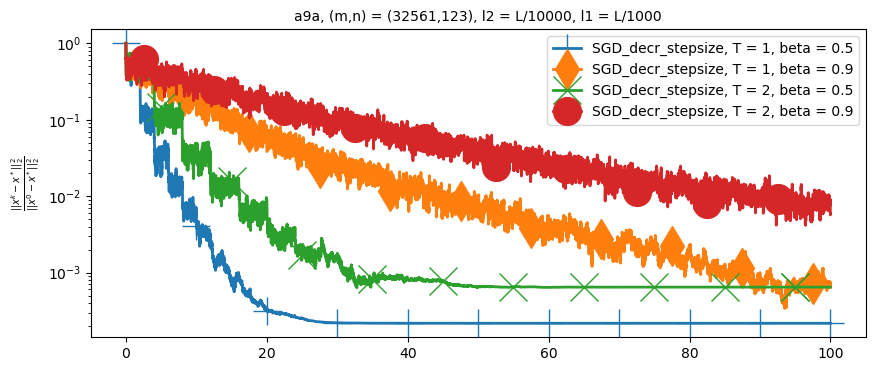

In [61]:
r = 1
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, 50, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

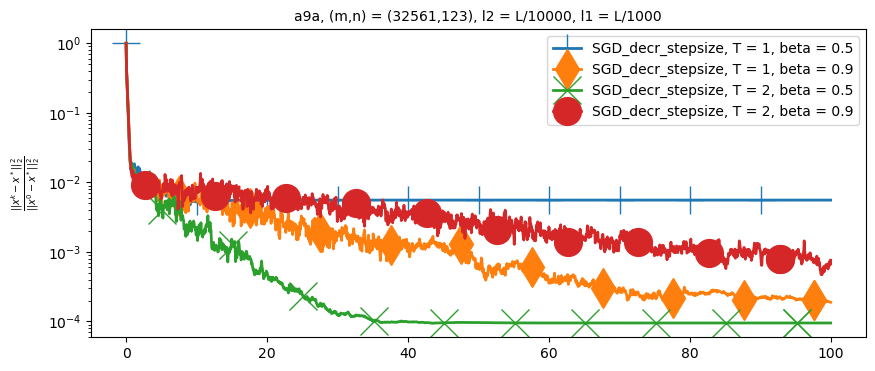

In [64]:
r = 10
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

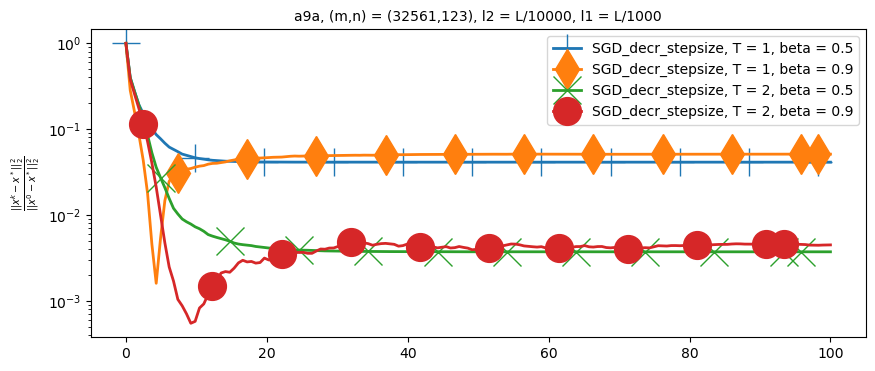

In [65]:
r = 100
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 4 experiment 2
Лучшая политика выбора шага: T = 2, $\beta$ = 0.5 при batch_size = 10.

### Task 4 experiment 3

**Теперь для обоих вариантов prox-SGD для каждого r выберите лучшие  
параметры ($\alpha$ – в первом случае, T, $\beta$ – во втором случае) для достижения точности $\epsilon = 10^{−3}$.
Они понадобятся для предпоследнего пункта.**

Курсивом выделены параметры, при которых достигается требуемая точность.

||prox-SGD const step| prox-SGD decr step|
|:-|-|-|
|**r=1**|alpha = 0.01|*T = 2, beta = 0.5*|
|**r=10**|alpha = 0.01|*T = 2, beta = 0.5*|
|**r=100**|*alpha = 0.1*|T = 2, beta = 0.5|

## Задание 5. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [180]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [181]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.63it/s]

CPU times: user 2.57 s, sys: 16 ms, total: 2.59 s
Wall time: 2.58 s


Запустите функцию, тестирующую корректность работы

In [182]:
prox_gd_test(res)

Тесты пройдены!


0

In [183]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этот параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [184]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 383.71it/s]

CPU times: user 2.6 s, sys: 20 ms, total: 2.62 s
Wall time: 2.61 s


Запустите функцию, тестирующую корректность работы

In [185]:
fista_test(res)

Тесты пройдены!


0

In [186]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [187]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 392.56it/s]

CPU times: user 2.56 s, sys: 38 µs, total: 2.56 s
Wall time: 2.55 s


Запустите функцию, тестирующую корректность работы

In [188]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

### Task 5 experiment 1 (prox-GD)

In [201]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 5000
save_info_period = 100
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 709.18it/s]


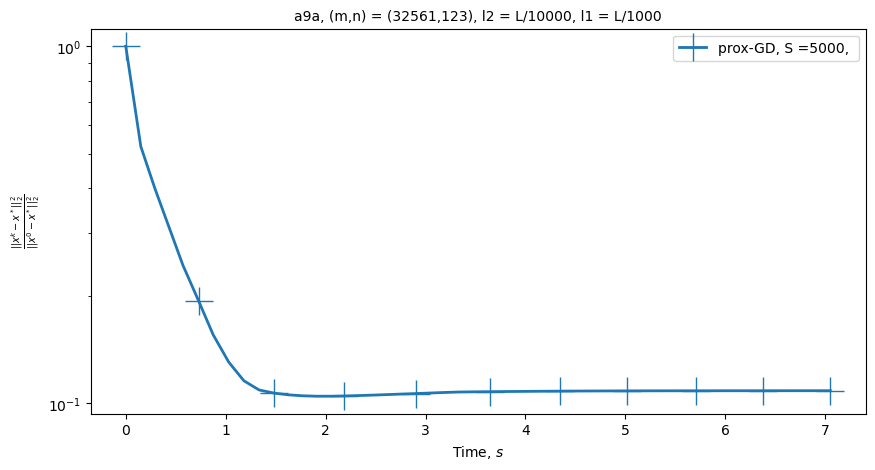

In [202]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (10, 5)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))


_, ax = plt.subplots(1, 1, figsize=figsize)
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

### Task 5 experiment 2 (FISTA)

In [193]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 5000
save_info_period = 100
sparse = False
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 735.11it/s]


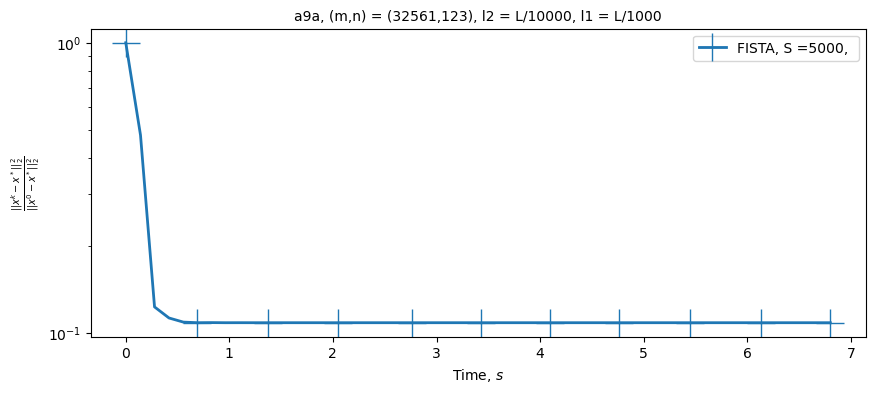

In [194]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

### Task 5 experiment 3 (GD)

In [211]:
for alpha in [1, 0.1, 0.01]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = None
    f_star = None
    S = 5000
    save_info_period = 100
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 733.28it/s]


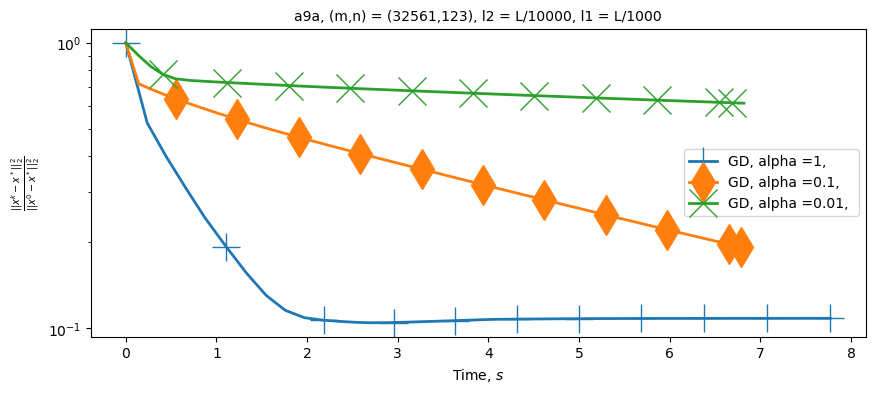

In [212]:
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['GD', [gamma * alpha, l2, l1, S], f', alpha = {alpha}, ', None] 
    for alpha in [1, 0.1, 0.01]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

mode_x = "time"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 5 experiments
Все три метода сходятся примерно к одной точке, но быстрее всех работает FISTA

## Задание 6. Сравнение методов

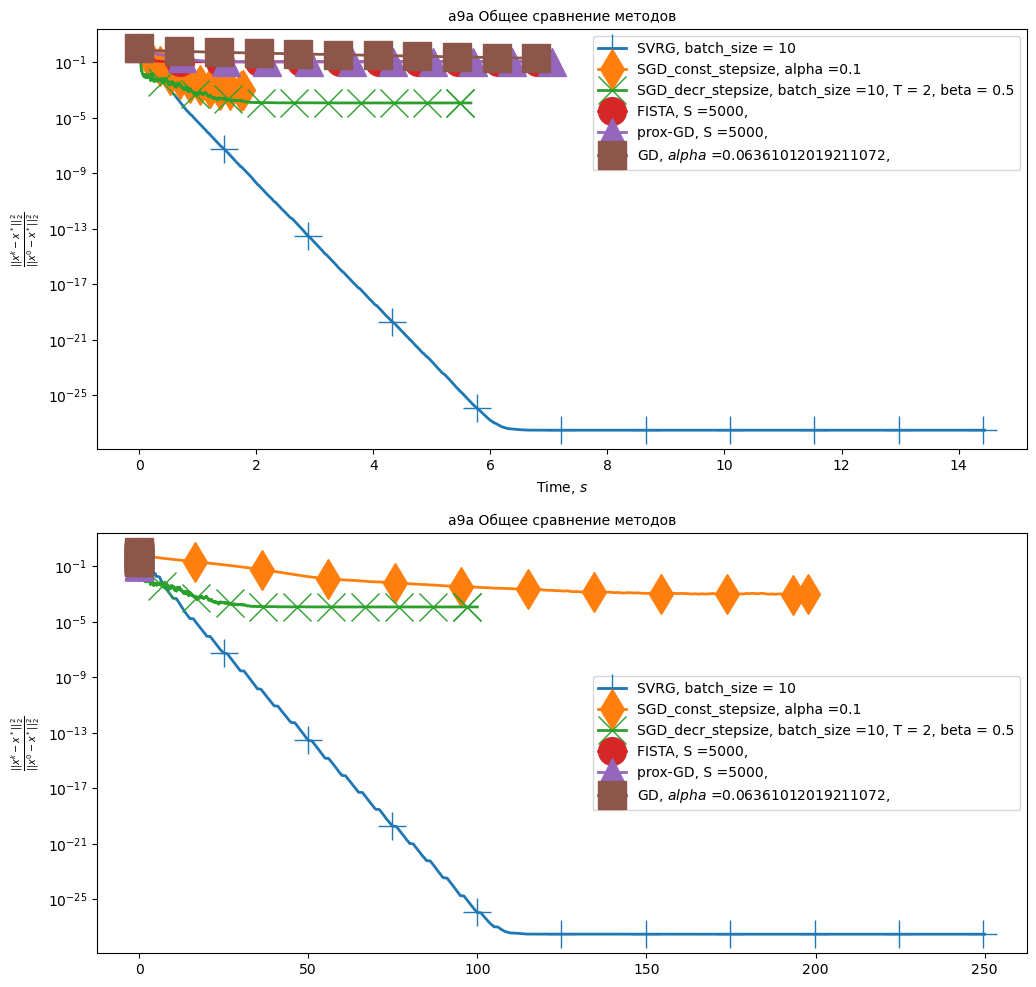

In [27]:
dataset = "a9a"
filename = dataset + "_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/((L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 50, int(2*m/10), 10], 
           f', batch_size = {10}', None], 
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 100, 100], 
           f', alpha ={0.1} ', None],    
    ['SGD_decr_stepsize', [[1.0/((L+l2)), 2, 0.5], l2, l1, 50, 10], 
           f', batch_size ={10}, T = {2}, beta = {0.5}', None],
    
    ['FISTA', [l2, l1, 5000], 
           f', S ={5000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 5000], 
       f', S ={5000}, ', None],
    
    ['GD', [0.1/((L+l2)),l2, l1, 5000], 
       f', $alpha$ ={0.1/((L+l2))}, ', None],
]
mode_y = 'squared_distances'
figsize = (12, 12)
fontsize = 10
title = dataset+" Общее сравнение методов"

_, axs = plt.subplots(2, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax)

### Conclusion on Task 6 experiments

Лучший результат показывает SVRG. SGD с постоянным шагом показывает неплохой результат, но, ожидаемо, при использовании уменшающегося шага результат лучше. Стохастические методы работают быстрее, по сравнению с методами, считающими полный градиент, поэтому, возможно, оставшимся методам не хватило времени, чтобы сойтись к более хорошему значению.

## Задание 7. Эксперименты с другим датасетом

# Diabetes experiments

In [66]:
%%time
dataset = "diabetes"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  768 , размерность задачи:  8
Константа гладкости всей функции:  8606.922539097417
Средняя константа гладкости     :  10862.250377252869
Худшая константа гладкости      :  189988.542101
Доля ненулевых элементов:  0.8758138020833334
CPU times: user 0 ns, sys: 3.55 ms, total: 3.55 ms
Wall time: 3.06 ms


## Task 3 Experiment 1 
(Custom vs Default solvers comparison for diabetes for l1 = 0 and l1 = L / 1000)

In [68]:
# Task 3 Experiment 1 (Custom vs Default solvers comparison for diabetes for l1 = 0 and l1 = L / 1000)

# ваш код здесь
# задать параметры
dataset = "diabetes"
filename = dataset + "_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [69]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.25it/s]

Найденное значение:  0.6923170714612407
Процент ненулевых координат в найденном решении:  0.125
CPU times: user 4.47 s, sys: 8.02 ms, total: 4.48 s
Wall time: 4.47 s


In [36]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [37]:
%%time
l1 = 0
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 220.28it/s]


Найденное значение:  0.6169843613592856
Процент ненулевых координат в найденном решении:  1.0
CPU times: user 4.54 s, sys: 8.08 ms, total: 4.55 s
Wall time: 4.54 s


In [39]:
%%time
l1 = L / 1000
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':False}, tol=1e-10)

print(res_solver.fun)

0.6935010754737475
CPU times: user 25.3 ms, sys: 0 ns, total: 25.3 ms
Wall time: 24.7 ms


In [40]:
%%time
l1 = 0
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':False}, tol=1e-10)

print(res_solver.fun)

0.6145824326089387
CPU times: user 17 ms, sys: 5 µs, total: 17 ms
Wall time: 16.6 ms


### Conclusion on Task 3 experiment 1
Как видно, найденные значения реализованного алгоритма и стандартного солвера для датасета diabetes примерно равны

## Task 3 Experiment 3 
(trying different batch sizes and for each - measuring time/num_iters/epochs)

In [41]:
# Task 3 Experiment 3 (trying different batch sizes and for each - measuring time/num_iters/epochs)

for r in [1, 10, 100]:
    dataset = "diabetes"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 1000
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1751.01it/s]


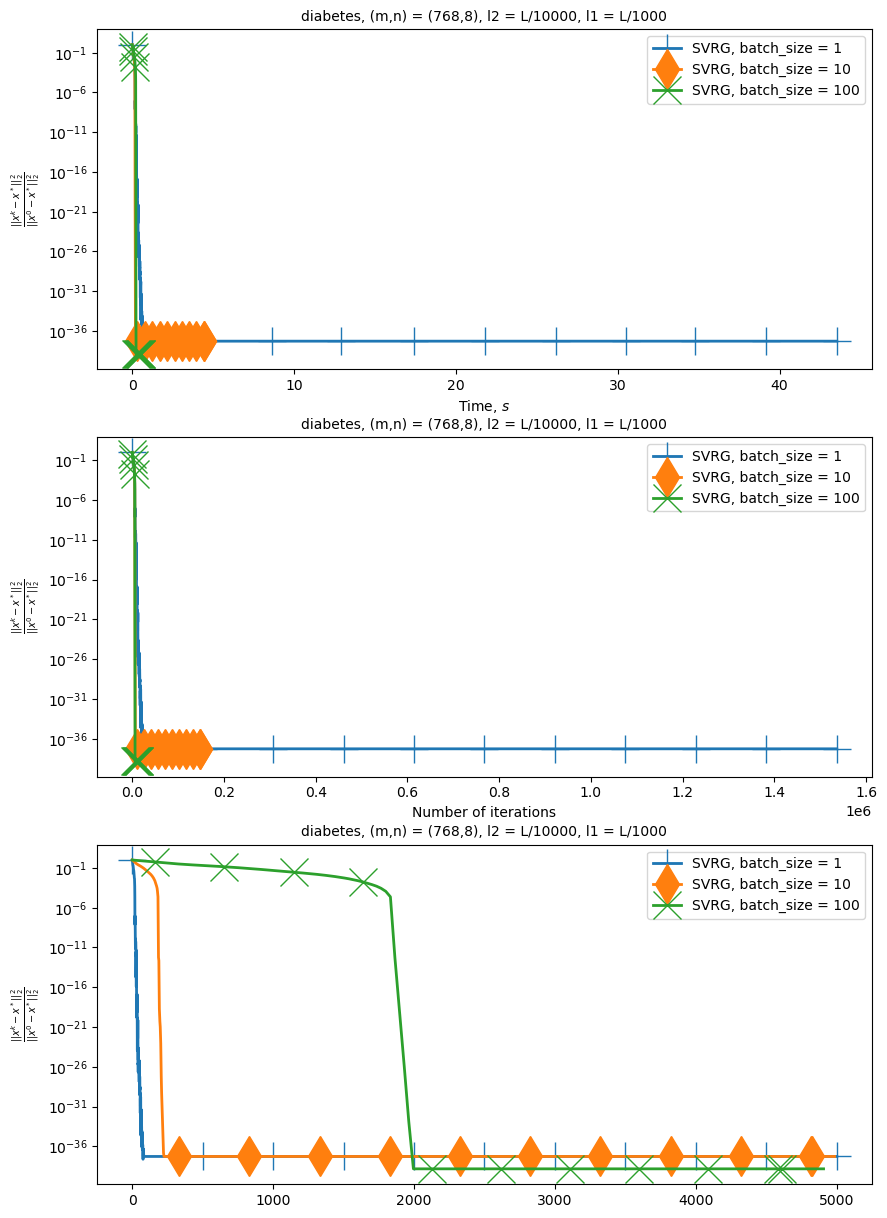

In [42]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 3 experiment 3
Как видно, быстрее всего метод сходится для батча размером 10

## Task 4 Experiment 1

Для каждого размера батча r = [1, 10, 100] запустите prox-SGD с размером шага $\gamma(\alpha) = \frac\alpha{L + l_2}$, $\alpha$ = 1, 0.1, 0.01. 
Для каждого значения r постройте графики сходимости prox-SGD с 
разными $\alpha$ (по числу итераций, эпох и времени работы).

In [70]:
r = 1
for alpha in [1, 0.1, 0.01]:
    dataset = "diabetes"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 1000
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 768000/768000 [00:14<00:00, 52875.36it/s]


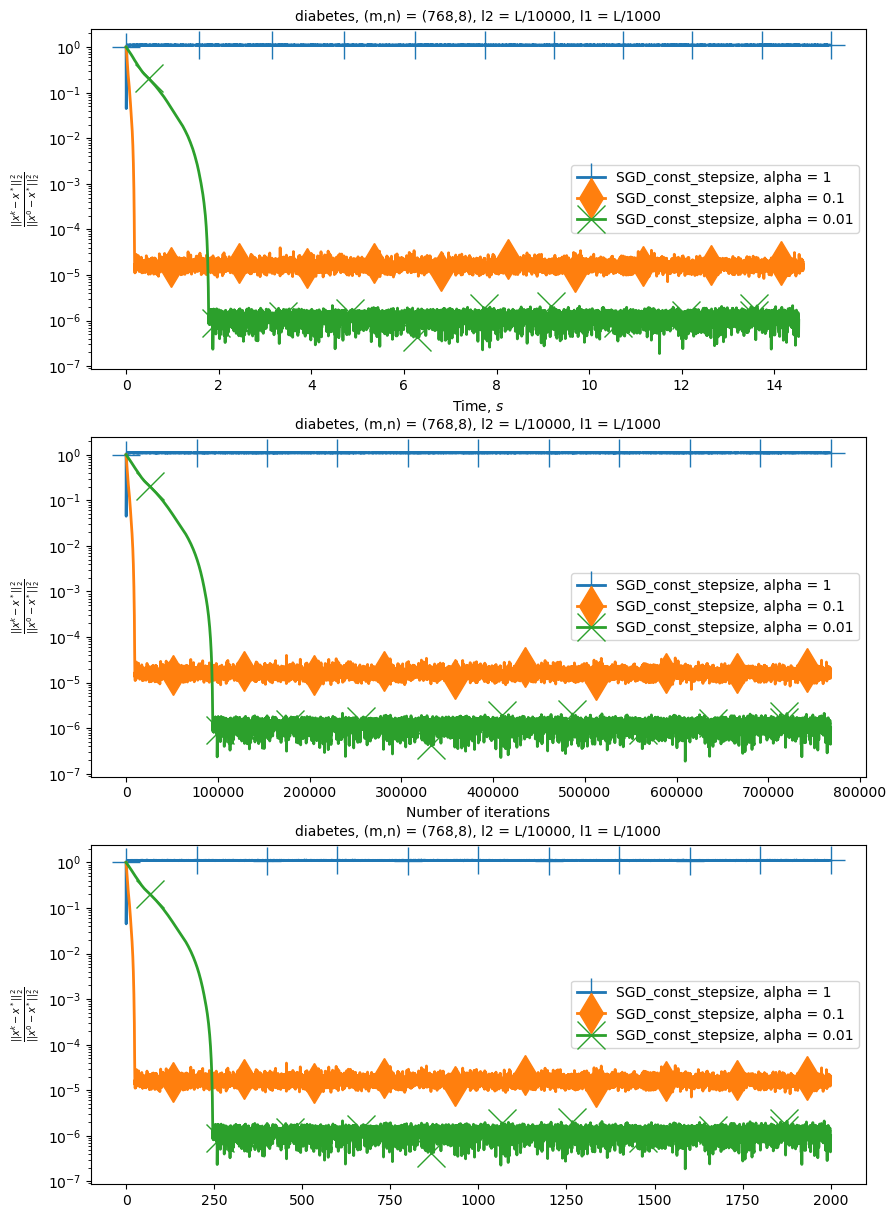

In [71]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None],
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

In [72]:
r = 10
for alpha in [1, 0.1, 0.01]:
    dataset = "diabetes"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 1000
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76800/76800 [00:01<00:00, 45273.94it/s]


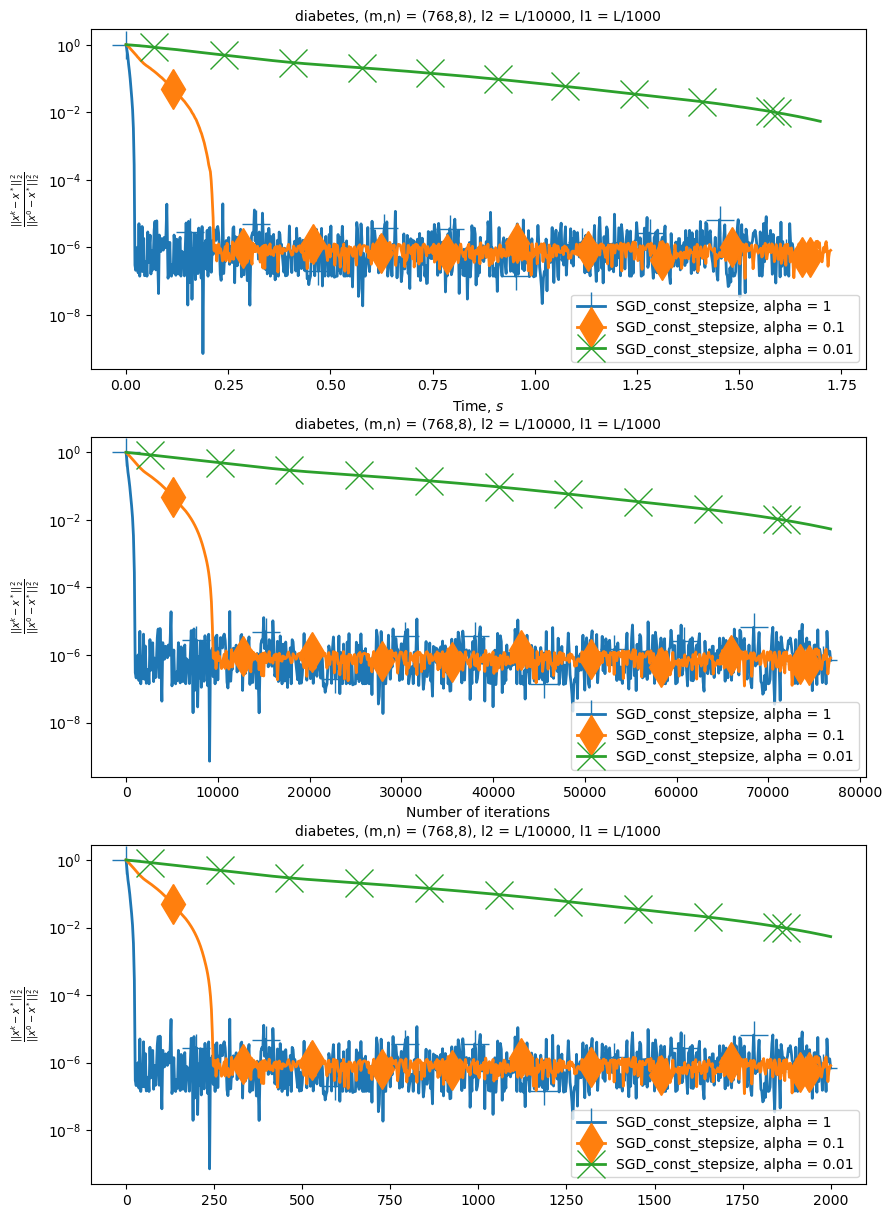

In [73]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

In [74]:
r = 100
for alpha in [1, 0.1, 0.01]:
    dataset = "diabetes"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 1000
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7680/7680 [00:00<00:00, 42886.60it/s]


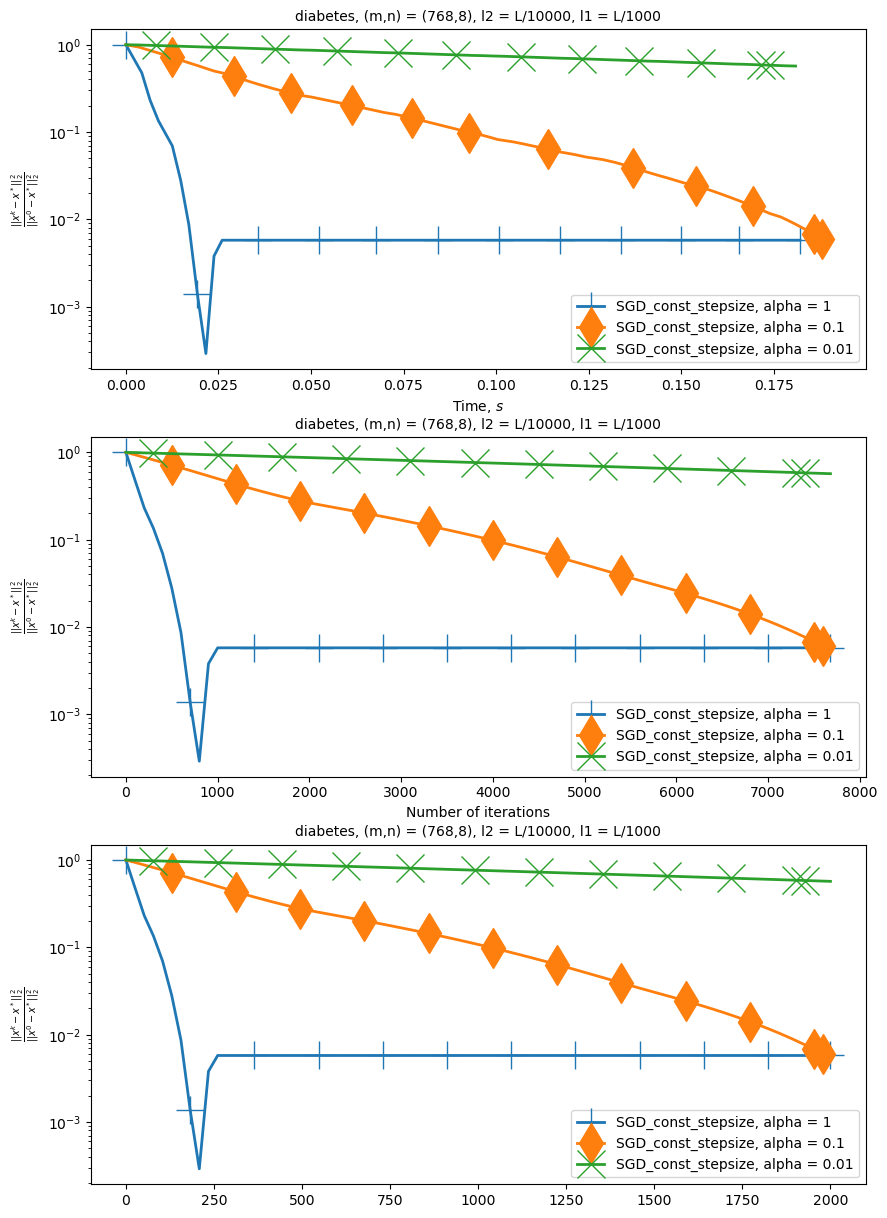

In [75]:
filename=dataset+"_x_init_all_ones"
alpha_1 = 1
alpha_01 = 0.1
alpha_001 = 0.01
gamma = 1.0/((L+l2))
methods = [
        ['SGD_const_stepsize', [gamma * alpha_1, l2, l1, S, r], 
           f', alpha = {alpha_1}', None],
        ['SGD_const_stepsize', [gamma * alpha_01, l2, l1, S, r], 
           f', alpha = {alpha_01}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SGD_const_stepsize', [gamma * alpha_001, l2, l1, S, r], 
           f', alpha = {alpha_001}', None],
]
mode_y = 'squared_distances'
figsize = (10, 15)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, axs = plt.subplots(3, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "iters", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 4 experiment 1
Лучшее alpha = 0.1 при batch_size = 10. При слишком большом значении метод может разойтись, при слишком малом будет долго сходиться.  
Так же на выбора alpha влияет размер батча.

## Task 4 experiment 2

Для каждого размера батча r = 1, 10, 100 запустите prox-SGD со стартовым размером шага $\gamma = \frac1{L + l_2}$.  
Попробуйте T = 1, 2 и $\beta$ = 0.5, 0.9 (4 варианта). Для каждого значения r постройте графики сходимости  
prox-SGD с разными политиками выбора T, $\beta$.

In [76]:
for r in [1, 10, 100]:
    for T in [1, 2]:
        for beta in [0.5, 0.9]:
            dataset = "diabetes"
            filename=dataset + "_x_init_all_ones"
            test_indices = None
            x_init = np.ones(n)
            l2 = L / 10000
            l1 = L / 1000
            batch_size = r
            M = int(2*m/batch_size)
            gamma = 1./(L+l2)
            x_star = read_solution(dataset, l2, l1)[0]
            f_star = read_solution(dataset, l2, l1)[1]
            S = 1000
            save_info_period = 100
            sparse_full = False
            sparse_stoch = False
            res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=[gamma, T, beta], 
                                    l2=l2, sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
                                    l1=l1, S=S, max_t=np.inf,
                                    batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
                                    x_star=x_star, f_star=f_star)
            save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7680/7680 [00:00<00:00, 42287.73it/s]


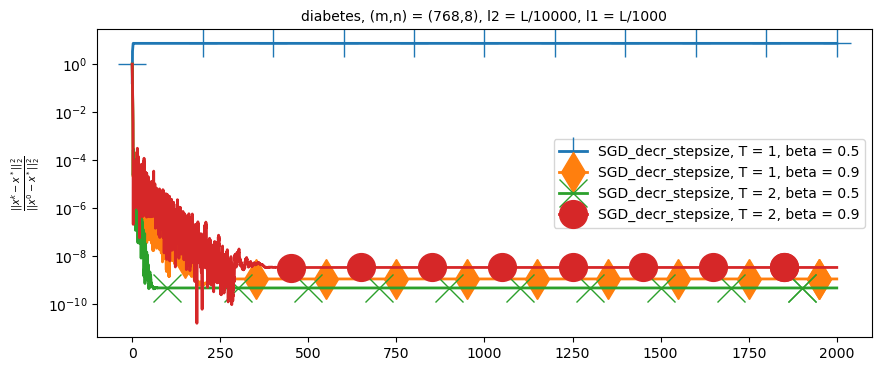

In [78]:
r = 1
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

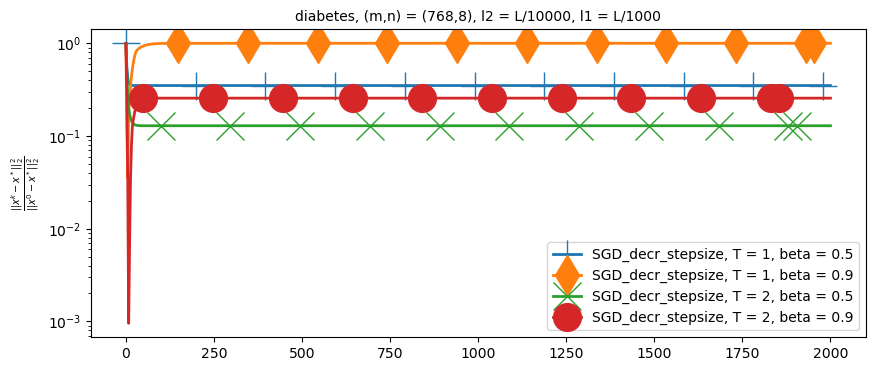

In [79]:
r = 10
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

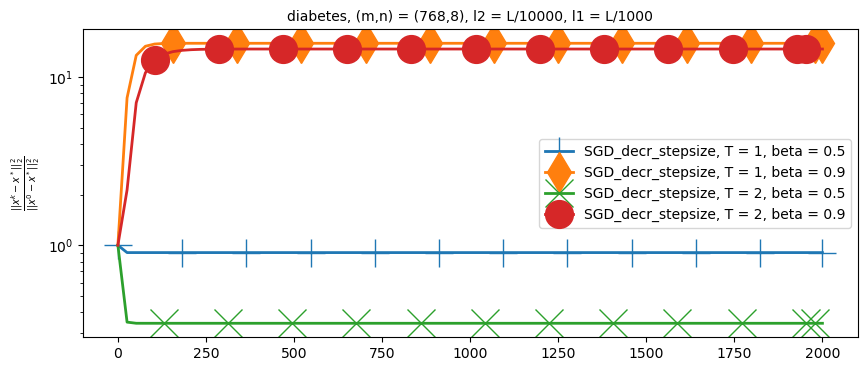

In [80]:
r = 100
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['SGD_decr_stepsize', [[gamma, T, beta], l2, l1, S, r], f', T = {T}, beta = {beta}', None] 
    for T in [1, 2] for beta in [0.5, 0.9]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
mode_x = "data_passes"
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

### Conclusion on Task 4 experiment 2
Лучшая политика выбора шага: T = 2, $\beta$ = 0.5 при batch_size = 1.

## Task 4 experiment 3

Теперь для обоих вариантов prox-SGD для каждого r выберите лучшие  
параметры ($\alpha$ – в первом случае, T, $\beta$ – во втором случае) для достижения точности $\epsilon = 10^{−3}$.
Они понадобятся для предпоследнего пункта.

*Курсивом выделены параметры, при которых достигается требуемая точность.*

||prox-SGD const step| prox-SGD decr step|
|:-|-|-|
|**r=1**|*alpha = 0.01*|*T = 2, beta = 0.5*|
|**r=10**|*alpha = 0.1*|T = 2, beta = 0.5|
|**r=100**|alpha = 1|T = 2, beta = 0.5|

## Task 5 experiment 1 (prox-GD)

In [82]:
dataset = "diabetes"
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 5000
save_info_period = 100
sparse = True
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 9030.50it/s]


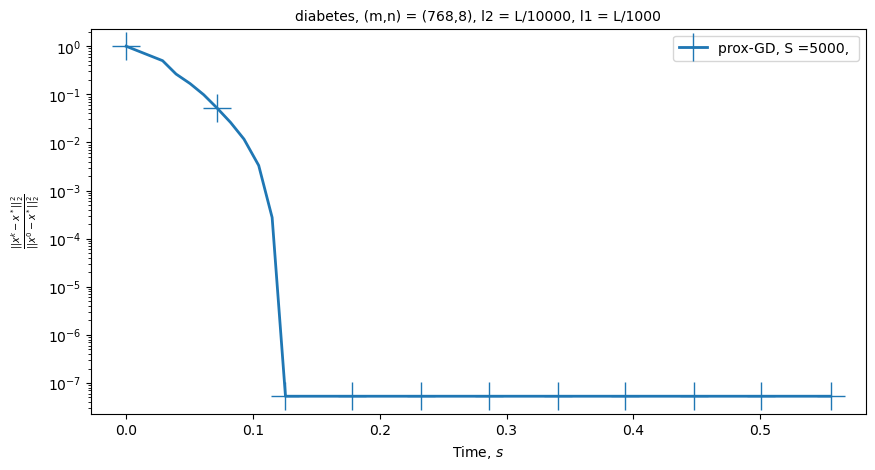

In [83]:
dataset = "diabetes"
filename=dataset+"_x_init_all_ones"

methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (10, 5)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))


_, ax = plt.subplots(1, 1, figsize=figsize)
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

## Task 5 experiment 2 (FISTA)

In [84]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 5000
save_info_period = 100
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Train epochs:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 8934.74it/s]


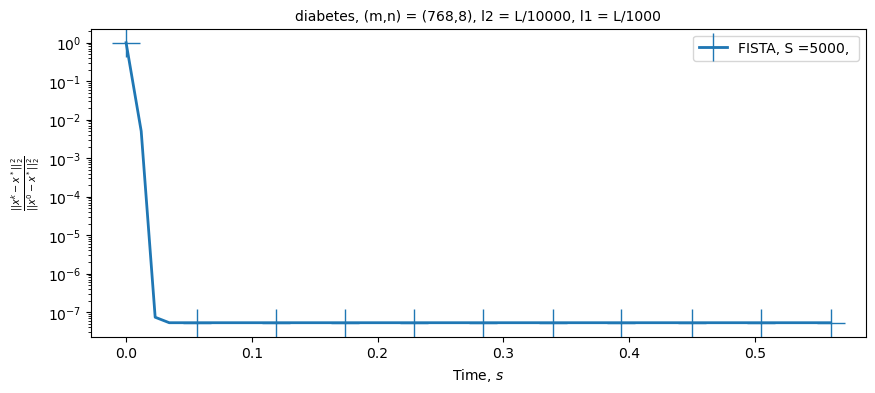

In [85]:
dataset = "diabetes"
filename=dataset+"_x_init_all_ones"

methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

_, ax = plt.subplots(1, 1, figsize=figsize)
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax);

## Task 5 experiment 3 (GD)

In [86]:
for alpha in [1, 0.1, 0.01]:
    dataset = "diabetes"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    M = int(2*m/batch_size)
    gamma = alpha/(L+l2)
    x_star = None
    f_star = None
    S = 5000
    save_info_period = 100
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Train epochs:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 13021.83it/s]


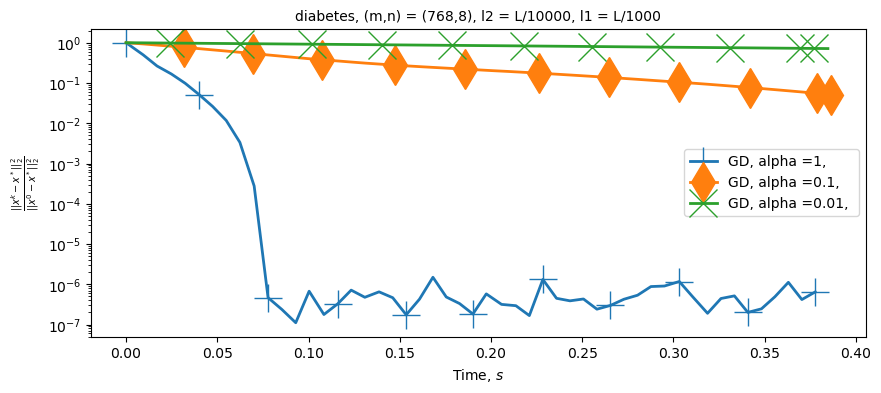

In [89]:
filename=dataset+"_x_init_all_ones"
gamma = 1.0/((L+l2))
methods = [
    ['GD', [gamma * alpha, l2, l1, S], f', alpha ={alpha}, ', None] 
    for alpha in [1, 0.1, 0.01]]
mode_y = 'squared_distances'
figsize = (10, 4)
fontsize = 10
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))
mode_x = "time"

_, ax = plt.subplots(1, 1, figsize=figsize)
args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots, ax=ax)

### Conclusion on Task 5 experiments
Все три метода сходятся примерно к одной точке, но быстрее всех работает FISTA

## Task 5 All methods comparison

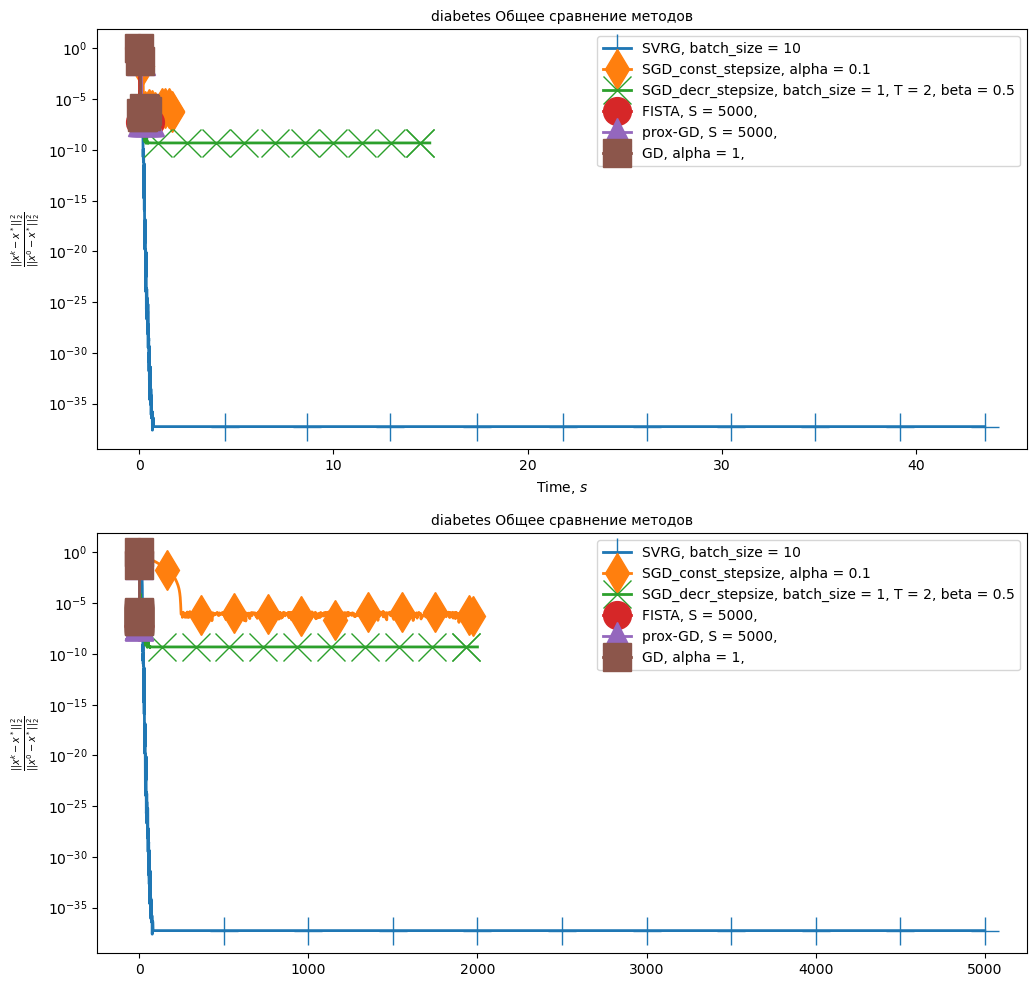

In [100]:
dataset = "diabetes"
filename = dataset + "_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/((L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 1000, int(2*m/1), 1], 
           f', batch_size = {10}', None], 
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 1000, 10], 
           f', alpha = {0.1} ', None],    
    ['SGD_decr_stepsize', [[1.0/((L+l2)), 2, 0.5], l2, l1, 1000, 1], 
           f', batch_size = {1}, T = {2}, beta = {0.5}', None],
    
    ['FISTA', [l2, l1, 5000], 
           f', S = {5000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 5000], 
       f', S = {5000}, ', None],
    
    ['GD', [1/((L+l2)),l2, l1, 5000], 
       f', alpha = {1}, ', None],
]
mode_y = 'squared_distances'
figsize = (12, 12)
fontsize = 10
title = dataset+" Общее сравнение методов"

_, axs = plt.subplots(2, 1, figsize=figsize)
for ax, mode_x in zip(axs, ["time", "data_passes"]):
    args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
    make_plots(args=args_for_plots, ax=ax)

### Conclusion on All methods comparison

Так же, как и для a9a, лучший результат показывает SVRG. SGD с постоянным шагом показывает неплохой результат, но, ожидаемо, при использовании уменшающегося шага результат лучше. В отличие от случая a9a, скорее всего из-за меньше размерности данных diabetes, методы, вычисляющие полный градиент, так же неплохо .